In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import argparse
import os
import random
import cv2
import torch.optim as optim
from torch.utils.data import DataLoader
from  torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler,autocast
from torch.autograd import Variable
import numpy as np
import pickle

In [ ]:
def weight_init(m):
    if isinstance(m, (nn.Conv2d,)):
        # print("Applying custom weight initialization for nn.Conv2d layer...")
        # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, mean=0.0,)
        if m.weight.data.shape == torch.Size([1, 6, 1, 1]):
            torch.nn.init.constant_(m.weight, 0.2) # for fuse conv
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

    # for fusion layer
    if isinstance(m, (nn.ConvTranspose2d,)):
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        # torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.weight.data.shape[1] == torch.Size([1]):
            torch.nn.init.normal_(m.weight, std=0.1)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [ ]:
class _DenseLayer(nn.Sequential):
    def __init__(self, input_features, out_features):
        super(_DenseLayer, self).__init__()

        # self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(input_features, out_features,
                                           kernel_size=1, stride=1, padding=1, bias=True)),
        self.add_module('norm1', nn.BatchNorm2d(out_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(out_features, out_features,
                                           kernel_size=3, stride=1, bias=True)),
        self.add_module('norm2', nn.BatchNorm2d(out_features))
        # double check the norm1 comment if necessary and put norm after conv2

    def forward(self, x):
        x1, x2 = x

        new_features = super(_DenseLayer, self).forward(F.relu(x1))  # F.relu()
        # if new_features.shape[-1]!=x2.shape[-1]:
        #     new_features =F.interpolate(new_features,size=(x2.shape[2],x2.shape[-1]), mode='bicubic',
        #                                 align_corners=False)
        return 0.5 * (new_features + x2), x2

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, input_features, out_features):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(input_features, out_features)
            self.add_module('denselayer%d' % (i + 1), layer)
            input_features = out_features

# class SqueezeExcitation(nn.Module):
#     def __init__(self, nb_channels, reduction=16):
#         super(SqueezeExcitation, self).__init__()
#         self.nb_channels=nb_channels
#         self.avg_pool=nn.AdaptiveAvgPool2d(1)
#         self.fc=nn.Sequential(
#                 nn.Linear(nb_channels, nb_channels // reduction),
#                 nn.ReLU(inplace=True),
#                 nn.Linear(nb_channels // reduction, nb_channels),
#                 nn.Sigmoid())

        
#     def forward(self, x):
#         y = self.avg_pool(x).view(-1,self.nb_channels)
#         y = self.fc(y).view(-1,self.nb_channels,1,1)
#         return x * y

class UpConvBlock(nn.Module):
    def __init__(self, in_features, up_scale):
        super(UpConvBlock, self).__init__()
        self.up_factor = 2
        self.constant_features = 16

        layers = self.make_deconv_layers(in_features, up_scale)
        assert layers is not None, layers
        self.features = nn.Sequential(*layers)

    def make_deconv_layers(self, in_features, up_scale):
        layers = []
        all_pads=[0,0,1,3,7]
        for i in range(up_scale):
            kernel_size = 2 ** up_scale
            pad = all_pads[up_scale]  # kernel_size-1
            out_features = self.compute_out_features(i, up_scale)
            layers.append(nn.Conv2d(in_features, out_features, 1))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.ConvTranspose2d(
                out_features, out_features, kernel_size, stride=2, padding=pad))
            in_features = out_features
        return layers

    def compute_out_features(self, idx, up_scale):
        return 1 if idx == up_scale - 1 else self.constant_features

    def forward(self, x):
        return self.features(x)

class SingleConvBlock(nn.Module):
    def __init__(self, in_features, out_features, stride,
                 use_bs=True
                 ):
        super(SingleConvBlock, self).__init__()
        self.use_bn = use_bs
        self.conv = nn.Conv2d(in_features, out_features, 1, stride=stride,
                              bias=True)
        self.bn = nn.BatchNorm2d(out_features)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        return x


class DoubleConvBlock(nn.Module):
    def __init__(self, in_features, mid_features,
                 out_features=None,
                 stride=1,
                 use_act=True):
        super(DoubleConvBlock, self).__init__()

        self.use_act = use_act
        if out_features is None:
            out_features = mid_features
        self.conv1 = nn.Conv2d(in_features, mid_features,
                               3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(mid_features)
        self.conv2 = nn.Conv2d(mid_features, out_features, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_act:
            x = self.relu(x)
        return x

In [ ]:
class DexiNed(nn.Module):
    """ Definition of the DXtrem network. """

    def __init__(self):
        super(DexiNed, self).__init__()
        self.block_1 = DoubleConvBlock(3, 32, 64, stride=2,)
        self.block_2 = DoubleConvBlock(64, 128, use_act=False)
        self.dblock_3 = _DenseBlock(2, 128, 256)
        self.dblock_4 = _DenseBlock(3, 256, 512)
        self.dblock_5 = _DenseBlock(3, 512, 512)
        self.dblock_6 = _DenseBlock(3, 512, 256)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # left skip connections, figure in Journal
        self.side_1 = SingleConvBlock(64, 128, 2)
        self.side_2 = SingleConvBlock(128, 256, 2)
        self.side_3 = SingleConvBlock(256, 512, 2)
        self.side_4 = SingleConvBlock(512, 512, 1)
        self.side_5 = SingleConvBlock(512, 256, 1)

        # right skip connections, figure in Journal
        self.pre_dense_2 = SingleConvBlock(128, 256, 2, use_bs=False)
        self.pre_dense_3 = SingleConvBlock(128, 256, 1)
        self.pre_dense_4 = SingleConvBlock(256, 512, 1)
        self.pre_dense_5_0 = SingleConvBlock(256, 512, 2,use_bs=False)
        self.pre_dense_5 = SingleConvBlock(512, 512, 1)
        self.pre_dense_6 = SingleConvBlock(512, 256, 1)

        # USNet
        self.up_block_1 = UpConvBlock(64, 1)
        self.up_block_2 = UpConvBlock(128, 1)
        self.up_block_3 = UpConvBlock(256, 2)
        self.up_block_4 = UpConvBlock(512, 3)
        self.up_block_5 = UpConvBlock(512, 4)
        self.up_block_6 = UpConvBlock(256, 4)
        self.block_cat = SingleConvBlock(6, 1, stride=1, use_bs=False)

        self.apply(weight_init)

    def slice(self, tensor, slice_shape):
        t_shape = tensor.shape
        height, width = slice_shape
        if t_shape[-1]!=slice_shape[-1]:
            new_tensor = F.interpolate(
                tensor, size=(height, width), mode='bicubic',align_corners=False)
        else:
            new_tensor=tensor
        # tensor[..., :height, :width]
        return new_tensor

    def forward(self, x):
        assert x.ndim == 4, x.shape

        # Block 1
        # print(f"x shape           : {x.shape}")
        block_1 = self.block_1(x)
        # print(f"block_1 shape     : {block_1.shape}")
        block_1_side = self.side_1(block_1)
        # print(f"block_1_side shape: {block_1_side.shape}")

        # Block 2
        block_2 = self.block_2(block_1)
        block_2_down = self.maxpool(block_2)
        block_2_add = block_2_down + block_1_side
        block_2_side = self.side_2(block_2_add)

        # Block 3
        block_3_pre_dense = self.pre_dense_3(block_2_down)
        block_3, _ = self.dblock_3([block_2_add, block_3_pre_dense])
        block_3_down = self.maxpool(block_3)
        block_3_add = block_3_down + block_2_side
        block_3_side = self.side_3(block_3_add)

        # Block 4
        block_4_pre_dense_256 = self.pre_dense_2(block_2_down)
        block_4_pre_dense = self.pre_dense_4(
            block_4_pre_dense_256 + block_3_down)
        block_4, _ = self.dblock_4([block_3_add, block_4_pre_dense])
        block_4_down = self.maxpool(block_4)
        block_4_add = block_4_down + block_3_side
        block_4_side = self.side_4(block_4_add)

        # Block 5
        block_5_pre_dense_512 = self.pre_dense_5_0(block_4_pre_dense_256)
        block_5_pre_dense = self.pre_dense_5(
            block_5_pre_dense_512 + block_4_down)
        block_5, _ = self.dblock_5([block_4_add, block_5_pre_dense])
        block_5_add = block_5 + block_4_side

        # Block 6
        block_6_pre_dense = self.pre_dense_6(block_5)
        block_6, _ = self.dblock_6([block_5_add, block_6_pre_dense])

        # upsampling blocks
        # height, width = x.shape[-2:]
        # slice_shape = (height, width)
        # out_1 = self.slice(self.up_block_1(block_1), slice_shape)
        out_1 = self.up_block_1(block_1)
        out_2 = self.up_block_2(block_2)
        out_3 = self.up_block_3(block_3)
        out_4 = self.up_block_4(block_4)
        out_5 = self.up_block_5(block_5)
        out_6 = self.up_block_6(block_6)
        results = [out_1, out_2, out_3, out_4, out_5, out_6]
        # print(out_1.shape,out_2.shape,out_3.shape,out_4.shape,out_5.shape,out_6.shape)
        # print(results.shape)

        # concatenate multiscale outputs
        block_cat = torch.cat(results, dim=1)  # Bx6xHxW
        block_cat = self.block_cat(block_cat)  # Bx1xHxW

        # return results
        results.append(block_cat)
        return results


In [ ]:
import numpy as np

def save_image_batch_to_disk(tensor,emp_mask):
    t=0
    tensor = torch.sigmoid(tensor) #.type(torch.float32)
    tensor = (tensor>0.5).float()
    tensor = tensor.cpu().numpy()
    emp_mask = emp_mask.squeeze()
    for i in range(6):    # 10
        for j in range(5):  # 7                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
          row,col = 400,400 #256,256
          img = tensor[t].transpose(1,2,0).squeeze()
          emp_mask[j*row:(j+1)*row,i*col:(i+1)*col] = cv2.bitwise_or(img, emp_mask[j*row:(j+1)*row,i*col:(i+1)*col], mask = None)
          t=t+1
    emp_mask = cv2.resize(emp_mask, (2592,1944))
    return emp_mask

In [ ]:
def color_balance(img):
  b, g, r = cv2.split(img)
  r_avg = cv2.mean(r)[0]
  g_avg = cv2.mean(g)[0]
  b_avg = cv2.mean(b)[0]
  
  # Find the gain of each channel
  k = (r_avg + g_avg + b_avg) / 3
  kr = k / r_avg
  kg = k / g_avg
  kb = k / b_avg
  
  r = cv2.addWeighted(src1=r, alpha=kr, src2=0, beta=0, gamma=0)
  g = cv2.addWeighted(src1=g, alpha=kg, src2=0, beta=0, gamma=0)
  b = cv2.addWeighted(src1=b, alpha=kb, src2=0, beta=0, gamma=0)
  
  balance_img = cv2.merge([b, g, r])
  return balance_img

In [ ]:
from torch.utils.data import Dataset
import cv2

def transform_single(id):
    all_img = []
    img = cv2.imread(id)
    img = color_balance(img)
    if img.shape== (1944, 2592, 3):
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (2400,2000))           ## Since majority of instances in a mask are not marked at the top region
      # img = cv2.resize(img, (2560,1792))
      # print(img)
      mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)          ## so cropping their top region to improve model performance
      mask = mask.reshape(mask.shape[0],mask.shape[1],1)
      # print(mask.shape)
      emp_mask = np.zeros(mask.shape, dtype=np.float32)
      # print(id, ' ', id_img[id])
      for i in range(6):    # 10
        for j in range(5):  # 7                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
          row,col = 400,400 #256,256
          img_c = img[j*row:(j+1)*row,i*col:(i+1)*col] #[j*243:(j+1)*243,i*324:(i+1)*324]#[j*486:(j+1)*486,i*648:(i+1)*648]     ## than resized to (270,270) and finally included in a list if its mask contains  
          img_c = img_c.transpose(2,0,1)
          img_norm = img_c/255
          p_img = torch.from_numpy(img_norm).type(torch.FloatTensor) #FloatTensor
          all_img.append(p_img)
         
    return all_img, emp_mask

class plant_dataset(Dataset):
  def __init__(self, img):
    self.img = img
    # self.mask = mask

  def __getitem__(self, index):
    img_id = self.img[index]
    # mask_id = self.mask[index]
    return img_id
  
  def __len__(self):
    return len(self.img)


In [ ]:
def test_single(test_loader, model, device, emp_mask):
    # Put model in evaluation mode
    model.eval()
    all_pred = []
    all_img = []
    # img = img_ins
    with torch.no_grad():
        for batch_id, (img) in enumerate(test_loader):
          # print(img.shape)
          img = img.view(-1,3,400,400).to(device)  #img.view(-1,3,256,256).to(device)   
          preds = model(img)[-1]
          # print(preds.shape)
          add_mask = save_image_batch_to_disk(preds, emp_mask)

    print('Testing finished')
    return preds, add_mask


In [ ]:
checkpoint_path = '/content/drive/My Drive/basil_leaves/new_dexined_epoch30_dc_0.323_fixeddataset.pth' 
device='cuda'
model = DexiNed().to(device)
if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint filte note found: {checkpoint_path}")
print(f"Restoring weights from: {checkpoint_path}")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

Restoring weights from: /content/drive/My Drive/basil_leaves/new_dexined_epoch30_dc_0.323_fixeddataset.pth


<All keys matched successfully>

In [ ]:
start = time()
## id of image for testing
id = '/content/drive/MyDrive/basil_leaves/images-1/2008RR000131AB-2020-11-28T04-11-07.jpg'
all_img, emp_mask = transform_single(id)
test_set = plant_dataset(all_img)
test_loader = DataLoader(test_set, batch_size = 30, shuffle = False)  #batch_size = 70
# out_pred,out_img = test_single(checkpoint_path, loaders['val'], model, device, output_dir)
# start = time()
out_pred,add_mask = test_single(test_loader, model, device, emp_mask)
end = time()

Testing finished


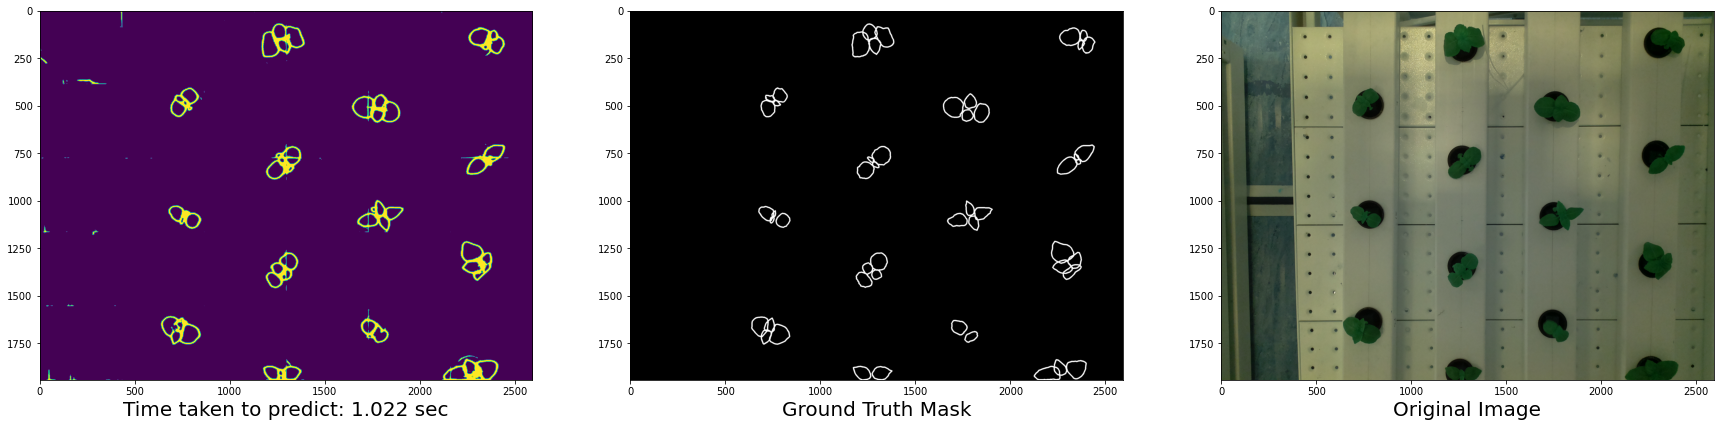

In [ ]:
import matplotlib.pyplot as plt
test_img = cv2.imread(id)
gt_dir = '/content/drive/MyDrive/basil_leaves/annotations_edge_jpg/'
gt_mask_id = gt_dir + id.split('/')[-1][:-4] + '_masked.jpg'
gt_mask = cv2.imread(gt_mask_id)
plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(add_mask)
plt.xlabel('Time taken to predict: {:.3f} sec'.format((end-start)), fontsize=20)
plt.subplot(132), plt.imshow(gt_mask)
plt.xlabel('Ground Truth Mask', fontsize=20)
plt.subplot(133), plt.imshow(test_img)
plt.xlabel('Original Image', fontsize=20)

plt.show()